# Bank Subscription classification methods

**Task:** <br>

Build a Classification model to predict if the client will subscribe (yes/no) a term deposit (variable y). Interpret the model and assess its predictive performance.
<br><br>
Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

## Attribute Information:

bank client data: 
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)s client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Source:
(Moro et al., 2014) S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


## Importing libraries and reading CSV file

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('bank.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
print('Number of rows:', len(df))

Number of rows: 4521


## Find NA values

In [4]:
df.isna().sum()
# there are no null values

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Checking for data type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 423.9+ KB


#### day variable will be left as int under the assumption that later part of the month will have more/less impact on the subscription

In [6]:
num_col = df._get_numeric_data().columns
cat_col = list(set(df.columns)-set(num_col))
cat_col.remove('y')
nominal_col = ['housing', 'month', 'default', 'marital', 'contact', 'job', 'loan', 'poutcome']
#ordinal_col = cat_col.remove(nominal_col)

In [7]:
ordinal_col = []
for col in cat_col:
    if col not in nominal_col:
        ordinal_col.append(col)
ordinal_col

['education']

## Checking for erroneous data
* checking unique values of categorical data
* checking min & max of numerical data

In [8]:
# checking for erroneous data in categorical data
for i in df[cat_col]:
    print(i,df[i].unique())

loan ['no' 'yes']
contact ['cellular' 'unknown' 'telephone']
month ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
education ['primary' 'secondary' 'tertiary' 'unknown']
poutcome ['unknown' 'failure' 'other' 'success']
marital ['married' 'single' 'divorced']
default ['no' 'yes']
housing ['no' 'yes']
job ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']


In [9]:
# checking for erroneous data in numerical data
df[num_col].describe()
# 'pdays' min should not be -1

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [10]:
# checking for erroneous data in dependent data
df['y'].unique()

array(['no', 'yes'], dtype=object)

## Data Cleaning
* replace all 'pdays' -1 to 0
* replace 'y' no to 1 and yes to 0 for classification model

In [11]:
df['pdays'] = df['pdays'].replace({-1:0})

In [12]:
df['y'] = df['y'].replace({'no':1, 'yes':0})
# replace string to integer for Classification model

## Exploratory Data Analytics

In [13]:
y_df = df.pivot_table(values='age', index='y', aggfunc='count')
y_df = y_df.rename({'age':'proportion'},axis=1)
y_df = y_df*100/len(df)
y_df

,proportion
y,
0,11.523999
1,88.476001


([<matplotlib.patches.Wedge at 0x113053f0>,
 [Text(-0.7791960661889841, 2.057389970432347, 'Subscribed'),
  Text(0.7791957772488503, -2.057390079862728, 'Not Subscribed')],
 [Text(-0.4250160361030822, 1.1222127111449163, '11.5%'),
  Text(0.42501587849937283, -1.122212770834215, '88.5%')])

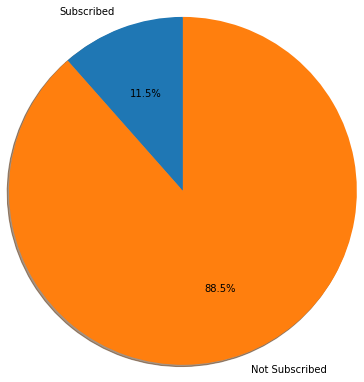

In [14]:
import matplotlib.pyplot as plt
plt.pie(y_df['proportion'], labels=['Subscribed', 'Not Subscribed'], autopct='%1.1f%%',
        shadow=True, startangle=90, radius = 2)

Imbalanced data set, with majority of the sample are not subscribed. The estimated ratio of subscribed to not subscribed is 1:9

In [15]:
df['y'].value_counts()

1    4000
0     521
Name: y, dtype: int64

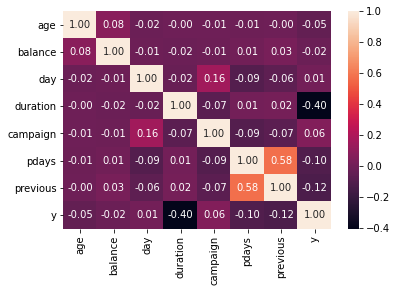

In [17]:
import matplotlib.pyplot as plt
corrs = df.corr()
sns.heatmap(corrs, annot=True, fmt='.2f')
plt.show()

### Observations
* Weak positive corr between 'pdays' and 'previous' - clients that were contacted long ago were contacted more frequently
* There is also a weak negative corr between 'duration' and 'y' - signifying that the longer since last contact, the more likely the client has not subscribed

## Reduce skewness in numerical data

In [18]:
skew_limit = 0.75
non_negative_num_col = num_col.drop('balance') # balance has a negative value
skew_cols = (df[non_negative_num_col].skew()
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols # very high skewness in features

,Skew
previous,5.875259
campaign,4.743914
duration,2.772420
pdays,2.723776


pop_orignial skewness:  5.875258677896706
pop_sqrt skewness:  2.518933556045291


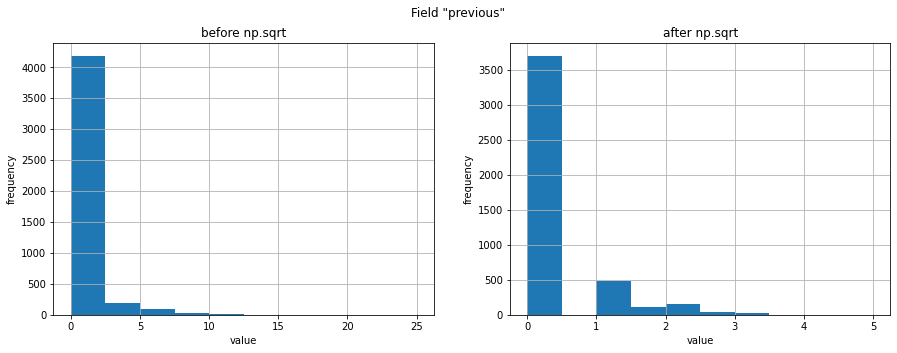

In [19]:
field = "previous"
fig, (ax_original, ax_sqrt) = plt.subplots(1, 2, figsize=(15, 5))

df[field].hist(ax=ax_original)

# Apply a log transformation (numpy syntax) to this column
df[field].apply(np.sqrt).hist(ax=ax_sqrt)

# Formatting of titles etc. for each subplot
ax_original.set(title='before np.sqrt', ylabel='frequency', xlabel='value')
ax_sqrt.set(title='after np.sqrt', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));
print('pop_orignial skewness: ',df[field].skew())
print('pop_sqrt skewness: ',df[field].apply(np.sqrt).skew())
# fall in skewness after log1p

In [20]:
# apply log1p across all numerical columns

for col in df[non_negative_num_col]:
# drop famrel as skewness increase after log1p
    df[col] = df[col].apply(np.sqrt)
new_skew_cols = (df[skew_cols.index].skew()
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'}))

skew_cols['New_skew'] = new_skew_cols
skew_cols['Difference'] = abs(skew_cols['New_skew']) - abs(skew_cols['Skew'])
skew_cols

,Skew,New_skew,Difference
previous,5.875259,2.518934,-3.356325
campaign,4.743914,2.147198,-2.596716
duration,2.772420,1.082597,-1.689822
pdays,2.723776,1.973276,-0.750500


## StandardScale numerical data 

In [21]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
for col in num_col:
    df[col] = ss.fit_transform(df[[col]])

## One hot encoding of categorical data

In [22]:
df = pd.get_dummies(df, columns=nominal_col,drop_first=True)
df.head()
# df is the transformed dataest for ML, df is the orignal dataset

,age,education,balance,day,duration,campaign,pdays,previous,y,housing_yes,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,loan_yes,poutcome_other,poutcome_success,poutcome_unknown
0,-1.099410,primary,0.121072,0.471887,-0.872100,-0.809033,-0.448112,-0.426934,1,0,...,0,0,0,0,1,0,0,0,0,1
1,-0.768469,secondary,1.118644,-0.452085,0.008184,-0.809033,2.718880,2.525344,1,1,...,0,1,0,0,0,0,1,0,0,0
2,-0.556145,tertiary,-0.024144,0.153724,-0.174105,-0.809033,2.676558,1.049205,1,1,...,0,0,0,0,0,0,0,0,0,0
3,-1.099410,tertiary,0.017726,-1.856803,-0.099280,0.703113,-0.448112,-0.426934,1,1,...,0,0,0,0,0,0,1,0,0,1
4,1.628858,secondary,-0.472753,-1.409994,0.037935,-0.809033,-0.448112,-0.426934,1,1,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# drop unknown and other inputs as this are not a reliable input
df = df.drop(['poutcome_unknown', 'poutcome_other', 'contact_unknown', 'job_unknown'], axis=1)

## Transform ordinal data into a numerical form

In [24]:
df['education'].unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

In [25]:
df['education'] = df['education'].replace({'unknown': 0, 'primary':1, 'secondary':2, 'tertiary':3})

In [26]:
# As all other numerical data are scaled via StandardScaler, we will MinMax scale the 'education' variable so that the influence of the coefficient of 'education' will not be too large
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
df['education'] = mm.fit_transform(df[['education']])
df['education'].head()

0    0.333333
1    0.666667
2    1.000000
3    1.000000
4    0.666667
Name: education, dtype: float64

## Stratified Train Test Split 

In [27]:
features = list(filter(lambda x: x!= 'y', df.columns))

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=3, test_size = 0.3,
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[features], df.y))

# Create the dataframes
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, 'y']

X_test  = df.loc[test_idx, features]
y_test  = df.loc[test_idx, 'y']

## PCA

In [29]:
# from sklearn.decomposition import PCA

# pca_list = list()
# feature_weight_list = list()

# # Fit a range of PCA models

# for n in range(0, 30,5):
    
#     # Create and fit the model
#     PCAmod = PCA(n_components=n)
#     PCAmod.fit(X_train)
    
#     # Store the model and variance
#     pca_list.append(pd.Series({'n':n, 'Model':PCAmod,
#                                'Var': PCAmod.explained_variance_ratio_.sum()}))
    
#     # Calculate and store feature importances
#     abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
#     feature_weight_list.append(pd.DataFrame({'n':n, 
#                                              'features': X_train.columns,
#                                              'values':abs_feature_values/abs_feature_values.sum()}))

# pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
# pca_df[1:]

In [30]:
# # to reduce the number of dimension to aid processing time, we set the leaast number of PC to explain 95% of the variance
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# print(pd.DataFrame(X_train))

## Model Evaluation

In [31]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer # Calcuate time elapsed in training model

def classif_report(name, model, threshold=0.5):
    prediction = model.predict_proba(X_test)
    # Classification Report
    prediction = np.where(prediction[:,1]>=threshold, 1, 0) 
    print("\u0332".join(name)+'\n')
    print(classification_report(y_test, prediction))

    # Confusion Matrix
    cf_matrix = confusion_matrix(y_test, prediction)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                cf_matrix.flatten()/np.sum(cf_matrix)]
    datalabels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]
    datalabels = np.asarray(datalabels).reshape(2,2)
    axislabels = ['Subscribed', 'Not Subscribed']
    con_mat = sns.heatmap(cf_matrix, annot=datalabels, fmt='', cmap='Blues', annot_kws={"size": 13}, xticklabels= axislabels, yticklabels=axislabels)
    con_mat.set_xticklabels(con_mat.get_xmajorticklabels(), fontsize = 12, verticalalignment = 'center', horizontalalignment = 'center')
    con_mat.set_yticklabels(con_mat.get_ymajorticklabels(), fontsize = 12, verticalalignment = 'center', horizontalalignment = 'center', rotation=90)
    plt.xlabel("\nPredictions")
    plt.ylabel("Ground Truth\n") 
    plt.show()

In [32]:
from sklearn.metrics import roc_curve, precision_recall_curve

def RocCurve(model):
    sns.set_context('talk')
    prediction = model.predict(X_test)

    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(8, 4)
    # Get the probabilities for each of the two categories
    y_prob = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob[:,1])

    # Plot the ROC-AUC curve
    ax = axList[0]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title="ROC Curve\nAUC={}".format(round(auc,3)))
    ax.grid(True)
    
    # Plot the precision-recall curve
    ax = axList[1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve')
    ax.grid(True)
    
    plt.tight_layout()
        
#     threshold_data = {'tpr-fpr':np.round(tpr-fpr,3), 'thresholds': np.round(thresholds,3)}
#     threshold_range = pd.DataFrame(threshold_data).drop(0,axis=0)
#     threshold_range = threshold_range.reset_index().drop(['index'],axis=1)
#     rate, optimal_threshold = threshold_range.iloc[threshold_range['tpr-fpr'].idxmax()]
#     print(threshold_range,'\n','Optimal threshold: ',optimal_threshold)

In [33]:
from sklearn.metrics import roc_curve, precision_recall_curve

def RocCurve_noproba(model):
    prediction = model.predict(X_test)
    auc = roc_auc_score(y_test, prediction)

The classification models are trained on the training dataset and evaluated on the test dataset, where the metrics for is F1 score and AUC. AUROC is calculated as the area under the curve of the receiver operating characteristic curve, signifying how well a model can predict the true positives and negatives. 

The F1 score represents the balance between recall and precision – how well a model can capture the true-positive, the errors of false-positive predictions and how many positives are not captured. Accuracy is not a good metric as the data is imbalanced; predicting all clients as non-subscriber will easily result in 88.5% accuracy, which is a misleading figure. Additionally, identifying clients that will not subscribe has more business value to a marketing campaign, thus accuracy is not sufficient and we use the F1 score for the best prediction without sacrificing too much precision or recall. 
Our strategy for choosing the best model is to attain a decent AUROC and have the highest F1 score.


## Dummy Classifier

Time Elapsed (sec): 0.001228699999046512


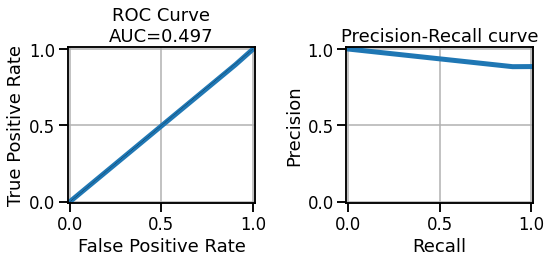

In [34]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")

start = timer()
dummy_clf.fit(X_train, y_train)

end = timer()
dummy_clf_time = end - start
print('Time Elapsed (sec):', dummy_clf_time)   
RocCurve(dummy_clf)

D̲u̲m̲m̲y̲ ̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

              precision    recall  f1-score   support

           0       0.14      0.13      0.14       156
           1       0.89      0.89      0.89      1201

    accuracy                           0.80      1357
   macro avg       0.51      0.51      0.51      1357
weighted avg       0.80      0.80      0.80      1357



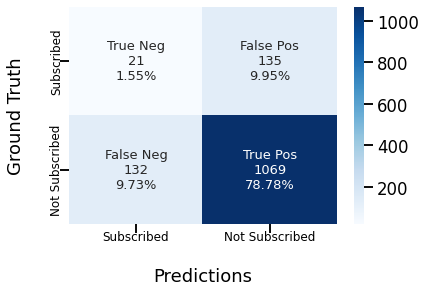

In [35]:
classif_report('Dummy Regression', dummy_clf) # threshold based on precision-recall curve

## Classification model
* Logistics regression 
* K-nearest neighbor
* Support vector classifier
* Decision tree (base and extra tree)
* Boosted decision tree (Gradient boosted and Ada boosted)
* Voting classifier

## Logistics Regression model with ridge regularization
Based on a sigmoid function, linear regression is transformed into a logistics regression that can predict the probability of non-subscription of each client.

Time Elapsed (sec): 1.1767681000001176


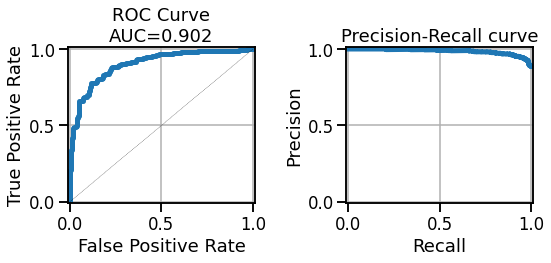

In [36]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

start = timer()
logit_reg = LogisticRegressionCV(Cs=5, cv=5, scoring= 'f1').fit(X_train, y_train)

end = timer()
logit_reg_time = end - start
print('Time Elapsed (sec):', logit_reg_time)   
RocCurve(logit_reg)

L̲o̲g̲i̲s̲t̲i̲c̲s̲ ̲R̲e̲g̲r̲e̲s̲s̲i̲o̲n

              precision    recall  f1-score   support

           0       0.69      0.40      0.50       156
           1       0.93      0.98      0.95      1201

    accuracy                           0.91      1357
   macro avg       0.81      0.69      0.73      1357
weighted avg       0.90      0.91      0.90      1357



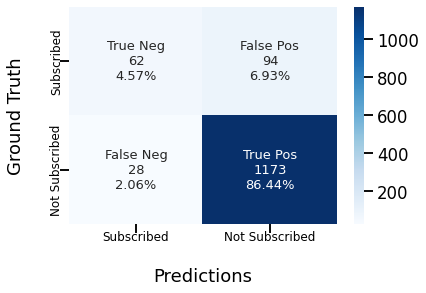

In [37]:
logit_threshold = 0.5
classif_report('Logistics Regression', logit_reg, threshold=logit_threshold) # threshold based on precision-recall curve

## K Nearest Neighbour Classification
The KNN model determines the subscription-based class using the K nearest (distance) datapoints, such that the class with the highest number of datapoints in K nearest datapoints will determine the class of the queried datapoint.

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [39]:
param_test = {
    'n_neighbors': [3,4,5],
    'weights': ['distance'],
    'metric': ['euclidean']
}

start = timer()
knn_grid = GridSearchCV(knn, param_grid = param_test, cv=5, scoring= 'f1').fit(X_train,y_train)

end = timer()
knn_time = end - start
print('Time Elapsed (sec):', knn_time) 
knn_grid.best_params_
knn_threshold = 0.65

Time Elapsed (sec): 3.3300524999995105


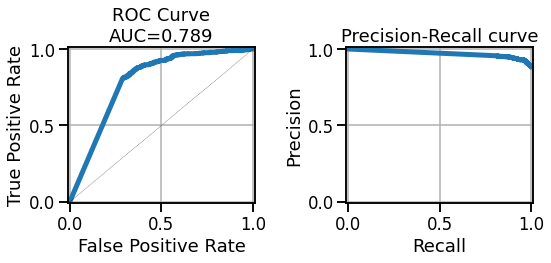

In [40]:
RocCurve(knn_grid)

K̲N̲N

              precision    recall  f1-score   support

           0       0.55      0.43      0.48       156
           1       0.93      0.96      0.94      1201

    accuracy                           0.89      1357
   macro avg       0.74      0.69      0.71      1357
weighted avg       0.88      0.89      0.89      1357



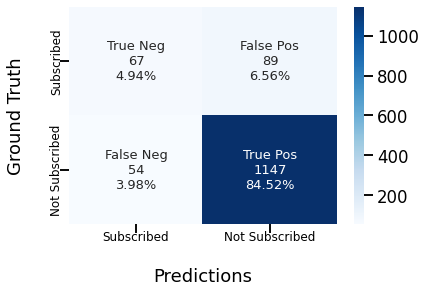

In [41]:
knn_threshold = 0.65
classif_report('KNN', knn_grid, threshold = knn_threshold) # threshold based on precision-recall curve

Comparing the confusion matrix from logistics regression and KNN, we observe that the negative predictions have decreased as KNN predictions tends towards not subscribed. However, the False positive rates have suffered, meaning that the predictions will have a higher rate of subscribed clients will be predicted as not subscribed

In [42]:
param_test = {
    'n_neighbors': [3,4,5],
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan']
}

start = timer()
knn_grid_manhat = GridSearchCV(knn, param_grid = param_test, cv=5, scoring= 'f1').fit(X_train,y_train)

end = timer()
knn_time_manhat = end - start
print('Time Elapsed (sec):', knn_time_manhat) 
knn_grid.best_params_
knn_threshold = 0.65

Time Elapsed (sec): 8.039644200000112


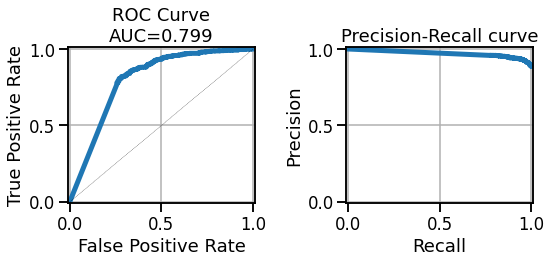

In [43]:
RocCurve(knn_grid_manhat)

Despite the high number of dimensions, the Euclidean distance model outperforms the Manhattan distance model as the AUROC for the Euclidean distance model is higher. 

## Support vector classifier
The SVC model makes predictions based on generating hyperplanes that best divides the subscribed and not subscribed classes. 

In [44]:
from sklearn.svm import SVC

SVC = SVC(probability=True)

param_test = {
    'gamma': [.5, 1, 2, 10]
}

start = timer()
SVC_grid = GridSearchCV(SVC, param_grid = param_test, cv=5, scoring= 'f1').fit(X_train,y_train)

end = timer()
SVC_time = end - start
print('Time Elapsed (sec):', SVC_time) 
SVC_grid.best_params_

Time Elapsed (sec): 84.1170946000002


{'gamma': 0.5}

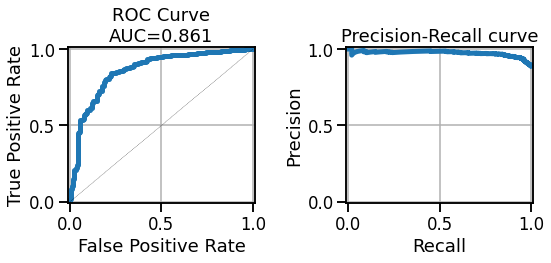

In [45]:
RocCurve(SVC_grid)

S̲V̲C

              precision    recall  f1-score   support

           0       0.58      0.45      0.51       156
           1       0.93      0.96      0.94      1201

    accuracy                           0.90      1357
   macro avg       0.76      0.70      0.73      1357
weighted avg       0.89      0.90      0.89      1357



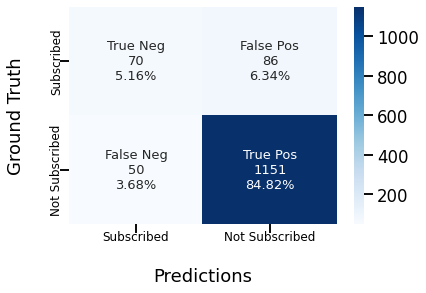

In [46]:
SVC_threshold = 0.7
classif_report('SVC',SVC_grid, threshold=SVC_threshold) # threshold based on precision-recall curve

## Random Foret Classifier
The Random forest classifier is an ensemble of individual decision trees, each trained on a different subset of features. Each decision tree will output a prediction and the class with the greatest number of predictions will become the overall prediction for the datapoint. This introduction of bias prevents overfitting of the model and improves overall variance. 

In [47]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(verbose=0)

In [48]:
# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, # using data that is left out for testing
                            random_state=42, 
                            warm_start=True, # reuse the solution of the previous call to fit and add more estimators to the ensemble
                            n_jobs=-1) # max number of concurrently running workers, -1 means use all cpu cores.

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees, max_depth=27, max_features ='sqrt')

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

C:\Users\Shaun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Shaun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,oob
n_trees,
15.0,0.123262
20.0,0.116308
30.0,0.110936
40.0,0.113148
50.0,0.114412
100.0,0.110936
150.0,0.107459
200.0,0.108407
300.0,0.105563


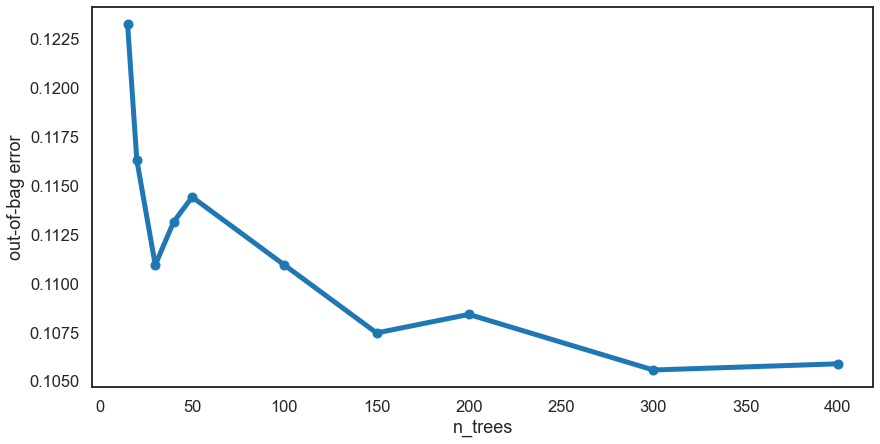

In [49]:
import seaborn as sns

# oob_error with the number of trees
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [50]:
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 3)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
param_test = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
            #    'bootstrap': bootstrap}

In [51]:
start = timer()
rfc = RandomForestClassifier(n_estimators=150)
rfc_grid = GridSearchCV(rfc, param_grid = param_test, scoring= 'f1').fit(X_train,y_train) #no need for kfold CV due to oob

end = timer()
rfc_time = end - start
print('Time Elapsed (sec):', rfc_time)
rfc_grid.best_params_

Time Elapsed (sec): 86.97297389999949


{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5}

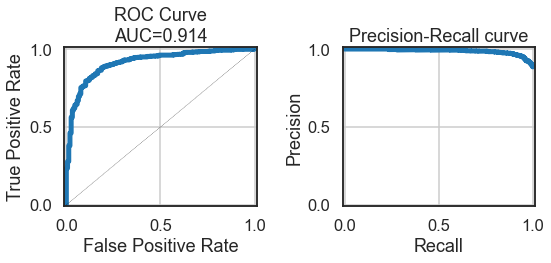

In [52]:
RocCurve(rfc_grid)

R̲a̲n̲d̲o̲m̲ ̲F̲o̲r̲e̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r

              precision    recall  f1-score   support

           0       0.68      0.26      0.37       156
           1       0.91      0.98      0.95      1201

    accuracy                           0.90      1357
   macro avg       0.79      0.62      0.66      1357
weighted avg       0.88      0.90      0.88      1357



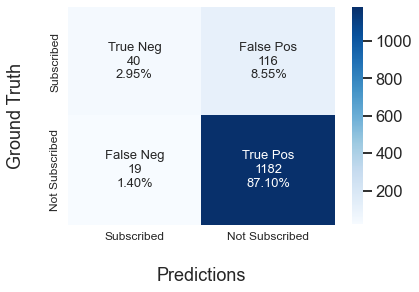

In [53]:
classif_report('Random Forest Classifier',rfc_grid)

## Extra Tree Classifier
Extra tree classifier adds further bias into the model by randomly selecting the split points instead of optimal split points, thus adding an additional layer of bias.

In [54]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True, # sample rows/entries with replacement
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

C:\Users\Shaun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Shaun\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


,oob
n_trees,
15.0,0.131479
20.0,0.119153
30.0,0.114728
40.0,0.112516
50.0,0.116308
100.0,0.110303
150.0,0.109039
200.0,0.109355
300.0,0.109355


In [55]:
start = timer()
EF = ExtraTreesClassifier(oob_score=True, n_estimators=100,
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True, # sample rows/entries with replacement
                          n_jobs=-1).fit(X_train, y_train)
end = timer()
EF_time = end - start
print('Time Elapsed (sec):', EF_time)

Time Elapsed (sec): 0.5046869999987393


E̲x̲t̲r̲a̲ ̲T̲r̲e̲e̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       156
           1       0.95      0.92      0.94      1201

    accuracy                           0.89      1357
   macro avg       0.73      0.77      0.75      1357
weighted avg       0.90      0.89      0.89      1357



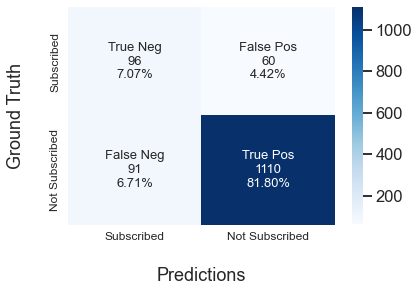

In [56]:
EF_threshold = 0.75
classif_report('Extra Tree Classifier',EF, EF_threshold)

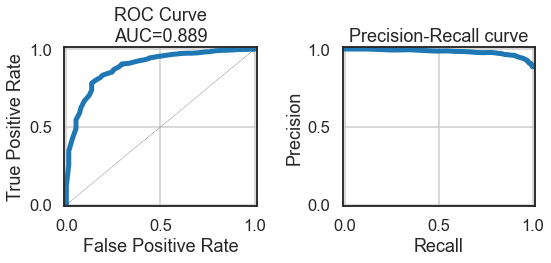

In [57]:
RocCurve(EF)

## Gradient Boosting
Gradient boosted decision tree is an ensemble of weak learners in sequential order, allowing the model to iteratively optimize from the residual of previous models. 

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, max_features=5)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train, y_train)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

GBC_oob_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

GBC_oob_df

Fitting model with 15 trees
Fitting model with 20 trees
Fitting model with 30 trees
Fitting model with 40 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 150 trees
Fitting model with 200 trees
Fitting model with 300 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.114223
20.0,0.114959
30.0,0.112749
40.0,0.100958
50.0,0.103906
100.0,0.092852
150.0,0.095800
200.0,0.097273
300.0,0.094326


In [59]:
start = timer()
GBC = GradientBoostingClassifier(n_estimators=150, max_features=5).fit(X_train, y_train)
end = timer()
GBC_time = end - start
print('Time Elapsed (sec):', GBC_time)

Time Elapsed (sec): 0.3709452999992209


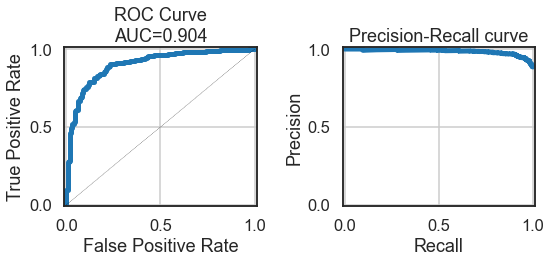

In [60]:
RocCurve(GBC)

G̲r̲a̲d̲i̲e̲n̲t̲ ̲B̲o̲o̲s̲t̲i̲n̲g̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r

              precision    recall  f1-score   support

           0       0.53      0.60      0.57       156
           1       0.95      0.93      0.94      1201

    accuracy                           0.89      1357
   macro avg       0.74      0.77      0.75      1357
weighted avg       0.90      0.89      0.90      1357



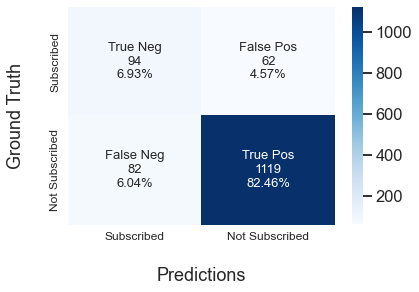

In [61]:
GBC_threshold = 0.75
classif_report('Gradient Boosting Classifier',GBC, GBC_threshold)

## ADABoost
Similarly, Ada boosting utilize stumps as base learners (1 level of depth) instead of multi-leveled trees.

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]
for n_trees in tree_list:
    
    # Initialize the ADAboost classifier
    ABC = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=n_trees, learning_rate=0.01)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    ABC.fit(X_train, y_train)
    y_pred = ABC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

ABC_oob_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

ABC_oob_df

Fitting model with 15 trees
Fitting model with 20 trees
Fitting model with 30 trees
Fitting model with 40 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 150 trees
Fitting model with 200 trees
Fitting model with 300 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.139278
20.0,0.139278
30.0,0.137804
40.0,0.138541
50.0,0.137804
100.0,0.142225
150.0,0.142962
200.0,0.140015
300.0,0.137804


In [64]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'}),
                    GBC_oob_df.rename(columns={'error':'Gradient Boosted'}),
                    ABC_oob_df.rename(columns={'error':'ADA Boosted'})], axis=1)

oob_df

,RandomForest,ExtraTrees,Gradient Boosted,ADA Boosted
n_trees,,,,
15.0,0.123262,0.131479,0.114223,0.139278
20.0,0.116308,0.119153,0.114959,0.139278
30.0,0.110936,0.114728,0.112749,0.137804
40.0,0.113148,0.112516,0.100958,0.138541
50.0,0.114412,0.116308,0.103906,0.137804
100.0,0.110936,0.110303,0.092852,0.142225
150.0,0.107459,0.109039,0.095800,0.142962
200.0,0.108407,0.109355,0.097273,0.140015
300.0,0.105563,0.109355,0.094326,0.137804


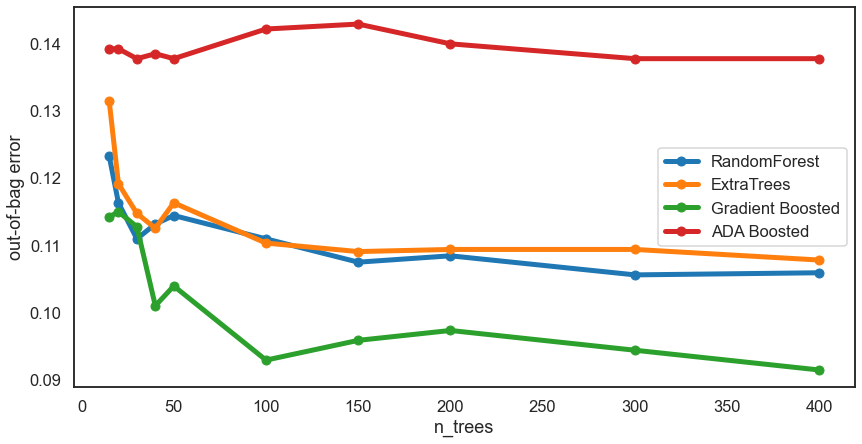

In [65]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [1]:
The out of bag error above allows us to optimal identify the number of trees in each model, improving processing efficiency and reduce overfitting. The chart however is not enough to determine the best tree-based model as it is based on accuracy, thus the determining metrics are still AUROC and F1 score.

SyntaxError: invalid syntax (<ipython-input-1-5f12d85f19b1>, line 1)

In [69]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.3]}

start = timer()
ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100)
ABC_grid = GridSearchCV(ABC,
                      param_grid=param_grid,
                      n_jobs=-1,scoring= 'f1').fit(X_train,y_train)

end = timer()
ABC_time = end - start
print('Time Elapsed (sec):', ABC_time)
ABC_grid.best_params_

Time Elapsed (sec): 11.541475299998638


{'learning_rate': 0.3}

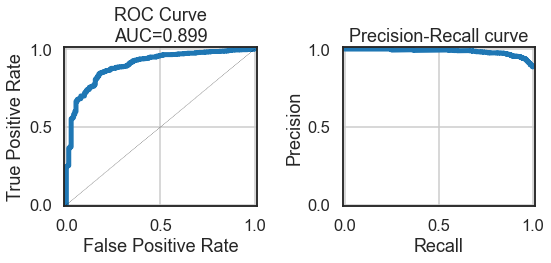

In [70]:
RocCurve(ABC_grid)

A̲d̲a̲ ̲B̲o̲o̲s̲t̲ ̲C̲l̲a̲s̲s̲i̲f̲i̲e̲r

              precision    recall  f1-score   support

           0       0.62      0.27      0.38       156
           1       0.91      0.98      0.94      1201

    accuracy                           0.90      1357
   macro avg       0.76      0.62      0.66      1357
weighted avg       0.88      0.90      0.88      1357



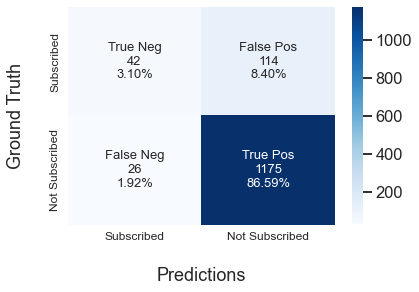

In [71]:
classif_report('Ada Boost Classifier',ABC_grid)

## Voting Class
The voting class wrapper combines 4 models (Logistics regression, KNN, Gradient boosting and Extra Tree) and enables soft voting to determine the class. This is done by averaging the predicted probability of the models; the class with the highest probability is the chosen class.

In [72]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('logit_reg', logit_reg), ('Knn', knn_grid), ('GBC', GBC), ('Extra Tree', EF)]

start = timer()
# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

end = timer()
VC_time = end - start
print('Time Elapsed (sec):', VC_time)

Time Elapsed (sec): 5.268168399999922


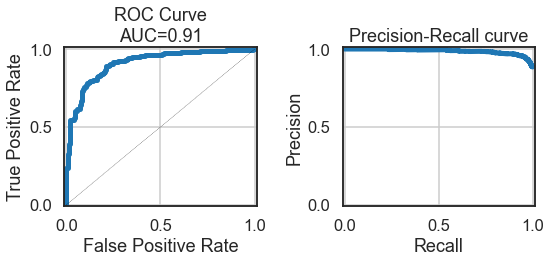

In [73]:
RocCurve(VC)

V̲o̲t̲i̲n̲g

              precision    recall  f1-score   support

           0       0.59      0.67      0.63       156
           1       0.96      0.94      0.95      1201

    accuracy                           0.91      1357
   macro avg       0.77      0.80      0.79      1357
weighted avg       0.91      0.91      0.91      1357



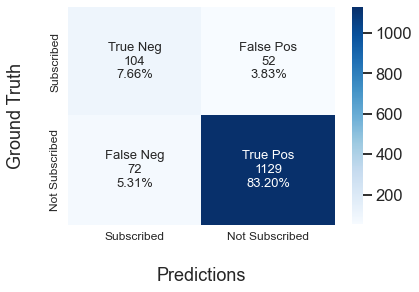

In [74]:
VC_threshold = 0.75
classif_report('Voting', VC, VC_threshold)

The voting classifier produces performance equal to gradient boosted tree and extra tree model. However, this is due to higher numbers of false negatives and less false positives than the other models. The voting classifier is better for predictions with higher precision, at the expense of recall

## Choosing the best model

In [75]:
# Logit, knn, svc have unique threshold values for optimal F1-score
dummy_clf_pred = dummy_clf.predict(X_test)
logit_reg_pred = np.where(logit_reg.predict_proba(X_test)[:,1]>=logit_threshold, 1, 0)
knn_grid_pred = np.where(knn_grid.predict_proba(X_test)[:,1]>=knn_threshold, 1, 0)
SVC_grid_pred = np.where(SVC_grid.predict_proba(X_test)[:,1]>=SVC_threshold, 1, 0)
rfc_grid_pred = rfc_grid.predict(X_test)
EF_pred = np.where(SVC_grid.predict_proba(X_test)[:,1]>=EF_threshold, 1, 0)
GBC_pred = np.where(SVC_grid.predict_proba(X_test)[:,1]>=GBC_threshold, 1, 0)
ABC_grid_pred = ABC_grid.predict(X_test)
VC_pred = np.where(SVC_grid.predict_proba(X_test)[:,1]>=VC_threshold, 1, 0)

model_pred = [dummy_clf_pred, logit_reg_pred, knn_grid_pred, SVC_grid_pred, rfc_grid_pred, EF_pred, GBC_pred, ABC_grid_pred, VC_pred]
time_elapsed = [dummy_clf_time,logit_reg_time, knn_time, SVC_time, rfc_time, EF_time, GBC_time, ABC_time,VC_time]

In [76]:
dummy_clf_pred_proba = dummy_clf.predict_proba(X_test)[:,1]
logit_reg_pred_proba = logit_reg.predict_proba(X_test)[:,1]
knn_grid_pred_proba = knn_grid.predict_proba(X_test)[:,1]
SVC_grid_pred_proba = SVC_grid.predict_proba(X_test)[:,1]
rfc_grid_pred_proba = rfc_grid.predict_proba(X_test)[:,1]
EF_pred_proba = EF.predict_proba(X_test)[:,1]
GBC_pred_proba = GBC.predict_proba(X_test)[:,1]
ABC_grid_pred_proba = ABC_grid.predict_proba(X_test)[:,1]
VC_pred_proba = VC.predict_proba(X_test)[:,1]

model_pred_proba = [dummy_clf_pred_proba, logit_reg_pred_proba, knn_grid_pred_proba, SVC_grid_pred_proba, rfc_grid_pred_proba, EF_pred_proba, GBC_pred_proba, ABC_grid_pred_proba, VC_pred_proba]

In [77]:
AUC = []
for pred in model_pred_proba:
    score = roc_auc_score(y_test, pred)
    AUC.append(round(score,3))

f1score = []
for pred in model_pred:
    score = f1_score(y_test, pred)
    f1score.append(round(score,3))

precision = []
for pred in model_pred:
    score = precision_score(y_test, pred)
    precision.append(round(score,3))

recall = []
for pred in model_pred:
    score = recall_score(y_test, pred)
    recall.append(round(score,3))

accuracy = []
for pred in model_pred:
    score = accuracy_score(y_test, pred)
    accuracy.append(round(score,3))

In [78]:
model_metrics = pd.DataFrame({'AUC':AUC, 'F1':f1score, 'Precision': precision, 'Recall':recall, 'Accuracy':accuracy, 'Time Elapsed':time_elapsed}, index = ['Dummy','Logistics Reg', 'K nearest neighbour', 'Support Vector', 'RandomForest', 'Extra Tree', 'Gradient Boosted', 'ADA Boosted', 'Voting Class'])
model_metrics

,AUC,F1,Precision,Recall,Accuracy,Time Elapsed
Dummy,0.495,0.880,0.886,0.874,0.789,0.001229
Logistics Reg,0.902,0.951,0.926,0.977,0.910,1.176768
K nearest neighbour,0.789,0.941,0.928,0.955,0.895,3.330052
Support Vector,0.861,0.944,0.930,0.958,0.900,84.117095
RandomForest,0.914,0.946,0.911,0.984,0.901,86.972974
Extra Tree,0.889,0.942,0.940,0.944,0.898,0.504687
Gradient Boosted,0.904,0.942,0.940,0.944,0.898,0.370945
ADA Boosted,0.899,0.944,0.912,0.978,0.897,11.541475
Voting Class,0.910,0.942,0.940,0.944,0.898,5.268168


We observe that Gradient Boosting has the best AUROC value, however the 'not subscribe' predictions have more business value, thus AUROC alone will not be optimal in classification as AUROC averages across all threshold values. AUROC will allows us to understand which models have a good balance between True postitives and False positives.
<p><br />
Therefore, we would also utilize the F1 score as our decision criteria, where the ensemble logistics regression produces the best F1 score. Additionally, it only take 1.7 seconds to train!
<p><br />
The random forest classifier achieved the 2nd best F1 score = 0.946, however it would take a significantly longer time to train as compared to other model, incurring higher cost.

## Thank you for reviewing!